<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#with open('data_Description.txt', mode='r') as file:
#    for line in file:
#        print(line)

## EDA

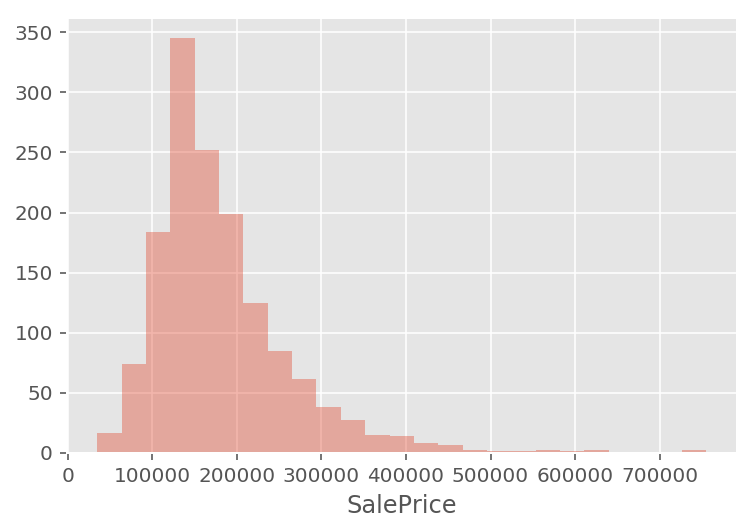

In [4]:
# look at the distribution of sale price
# skewed right
sns.distplot(house.SalePrice, kde=False, bins=25)
plt.show()

In [5]:
# calculate the age of the house when sold
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt

/Users/klara/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


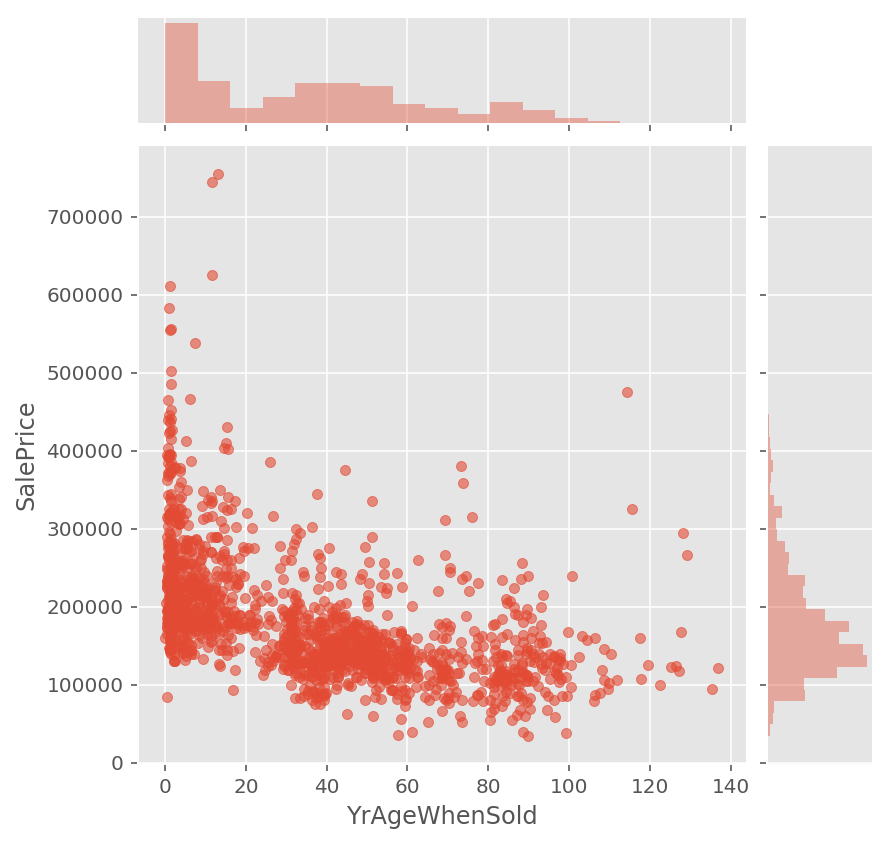

In [6]:
# plot the age of the house vs. the log sale price
# defnitely some strong signal in there
sns.jointplot(house.YrAgeWhenSold, house.SalePrice, joint_kws=dict(s=25, alpha=0.6));

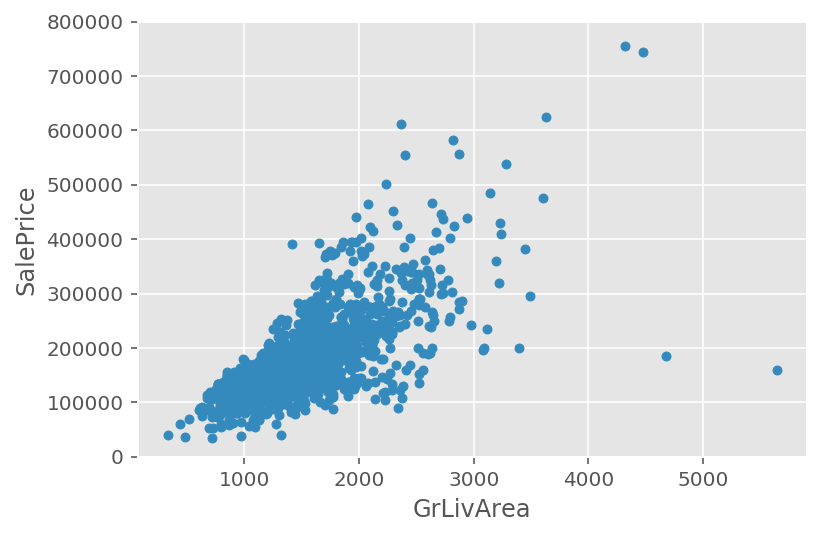

In [7]:
#scatter plot grlivarea/saleprice
y=house['SalePrice']
var = house['GrLivArea']
data = pd.concat([y, var], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

Linear relationship betweem 'above grade (ground) living area square feet' and the 'sales price'.

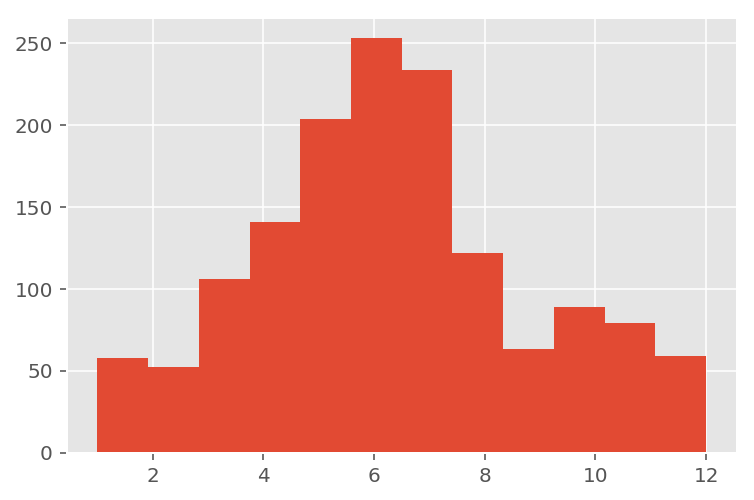

In [8]:
#more houses sold in the summer
house.MoSold.hist(bins=12);

## Cleaning

In [9]:
house.shape

(1460, 82)

In [10]:
house.dtypes.head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

In [11]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
house.dropna(how='all').shape

(1460, 82)

In [13]:
# Some numerical features are actually categories
house = house.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [14]:
house.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [15]:
house.isnull().values.sum()

6965

In [16]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [17]:
missing_values_table(house)

Your selected dataframe has 82 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


First we need to look at the chategirical variables, where the missing value only means that the property does not contains that item (for example data description says NA for garage features is "no garage"), so we do not have to take that into consideration, because when we turn them into dummy variables later it would also count as a category. So we need to get back to this matter after the dummification.

Below is a summary highlight of several options we have for handling missing values.

--> DROP MISSING VALUES

--> FILL MISSING VALUES WITH TEST STATISTIC

--> PREDICT MISSING VALUE WITH A MACHINE LEARNING ALGORITHM

Filling missing values with test statistics is the most common method of handling missing values according to some resources. This is a process whereby missing values are replaced with a test statistic like mean, median or mode of the particular feature the missing value belongs to.

In [18]:
# Lots of variables have nulls. Some are continuous, others categorical.
# I wrote a function to fill in both. The categorical ones can be filled
# with "None" because that's what the NA means (based on the data description
# file). A few of the continuous ones can be filled with 0 as that is their 
# meaning.

# I am dropping Electrical, PoolQC, and Id. The first two have no variance - 
# useless variables. The Id is just an identifier of the house.
def col_filler(df, col, fillval='None'):
    df.loc[df[col].isnull(), col] = fillval
    return df

none_fill_cols = ['GarageType','GarageFinish','GarageQual','GarageCond','Fence',
                  'FireplaceQu','BsmtFinType2','BsmtFinType1','BsmtExposure',
                  'BsmtCond','BsmtQual','MasVnrType','MiscFeature']

zero_fill_cols = ['Alley','LotFrontage','MasVnrArea']

drop_rows = ['Electrical']
drop_cols = ['PoolQC','Id']

In [19]:
for col in none_fill_cols:
    house = col_filler(house, col, fillval='None')
    
for col in zero_fill_cols:
    house = col_filler(house, col, fillval=0.)
    
for col in drop_rows:
    house = house[~house[col].isnull()]
    
for col in drop_cols:
    house.drop(col, axis=1, inplace=True)

Be sure to remove any houses that are not residential from the dataset.

In [20]:
house['MSZoning'].value_counts()

RL         1150
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [21]:
# dfh = pd.DataFrame(house, index = house['MSZoning'])
dfh = house[house.MSZoning != "C (all)"]
dfh['MSZoning'].value_counts()

RL    1150
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

Identify fixed features that can predict price.

In [22]:
missing_values_table(house)

Your selected dataframe has 80 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
GarageYrBlt,81,5.6


In [23]:
# drop due to the missing values. 
house.drop('GarageYrBlt', axis=1, inplace=True)

In [24]:
missing_values_table(house)

Your selected dataframe has 79 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Modeling

Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV

### Droping the unecesary features

In [26]:
# If a feature is the same value for more than 95% of observations,
# drop it.
def proportion_majority(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [27]:
props = [[col,proportion_majority(house, col)] for col in house.columns]
props = pd.DataFrame(props, columns=['feature','majority'])
# columns where the proportion of the majority class is greater than 95%
props[props.majority > 0.95]

,feature,majority
4,Street,0.995888
8,Utilities,0.999315
13,Condition2,0.989719
21,RoofMatl,0.982180
38,Heating,0.978067
44,LowQualFinSF,0.982180
51,KitchenAbvGr,0.953393
67,3SsnPorch,0.983550
69,PoolArea,0.995202
71,MiscFeature,0.962988


In [28]:
prop_remove_cols = props[props.majority > 0.95].feature.values
h = house.drop(prop_remove_cols, axis=1)

### Dumification

In [29]:
h.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'Fence', 'MoSold', 'YrSold', 'SaleType',
       'SaleCon

In [30]:
features_fixed = pd.DataFrame(h[['MSZoning', 'LotFrontage', 'LotArea',
     'LotShape', 'LandContour','LotConfig',
       'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle','YearBuilt', 'MasVnrType',
       'MasVnrArea', 'Foundation', 'BsmtExposure', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'Fence',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd','Fireplaces', 'GarageType',
      'GarageCars', 'GarageArea', 'OpenPorchSF', 'SaleCondition',
       'EnclosedPorch', 'ScreenPorch', 'YrSold']])
features_fixed.head()


,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,...,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,GarageArea,OpenPorchSF,SaleCondition,EnclosedPorch,ScreenPorch,YrSold
0,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,...,8,0,Attchd,2,548,61,Normal,0,0,2008
1,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,1Fam,1Story,...,6,1,Attchd,2,460,0,Normal,0,0,2007
2,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,...,6,1,Attchd,2,608,42,Normal,0,0,2008
3,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,1Fam,2Story,...,7,1,Detchd,3,642,35,Abnorml,272,0,2006
4,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,1Fam,2Story,...,9,1,Attchd,3,836,84,Normal,0,0,2008


In [31]:
features_dum = pd.get_dummies(features_fixed)
X = features_dum

In [32]:
y = h.pop('SalePrice')

In [33]:
X_train = X[features_dum['YrSold'].isin([2006, 2007, 2008, 2009])]
X_test = X[features_dum['YrSold'] == 2010]

y_train = y[h['YrSold'].isin([2006, 2007, 2008, 2009])]
y_test = y[h['YrSold'] == 2010]
X_train.head()

,LotFrontage,LotArea,YearBuilt,MasVnrArea,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,196.0,856,854,1710,1,0,2,...,0,0,0,0,0,0,0,0,1,0
1,80.0,9600,1976,0.0,1262,0,1262,0,1,2,...,0,0,0,0,0,0,0,0,1,0
2,68.0,11250,2001,162.0,920,866,1786,1,0,2,...,0,0,0,0,0,0,0,0,1,0
3,60.0,9550,1915,0.0,961,756,1717,1,0,1,...,0,0,1,0,1,0,0,0,0,0
4,84.0,14260,2000,350.0,1145,1053,2198,1,0,2,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# standardizing the data, it is necessary because the beta values for each predictor variable must be on the same scale.
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

/Users/klara/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/klara/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/klara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [35]:
# create a linear regression model instance
model = LinearRegression()

# get cross validated scores
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

Cross-validated training scores: [0.85603143 0.78130158 0.82198266 0.80685078 0.69255713]
Mean cross-validated training score: 0.7917447138093672


In [36]:
# fit and evaluate the data on the whole training set
model.fit(X_train,y_train)

print("Training Score:",model.score(X_train,y_train))
print("Test Score:",model.score(X_test,y_test))

Training Score: 0.8442581737633343
Test Score: 0.8640176335971227


In [37]:
model_coef = pd.DataFrame(model.coef_, index=X_train.columns, columns=['coefficients'])
model_coef.sort_values(by='coefficients', ascending=False).head()

,coefficients
BldgType_1Fam,1.292886e+16
BldgType_TwnhsE,9.360502e+15
MasVnrType_None,8.337631e+15
MasVnrType_BrkFace,7.826884e+15
LotShape_Reg,6.896141e+15


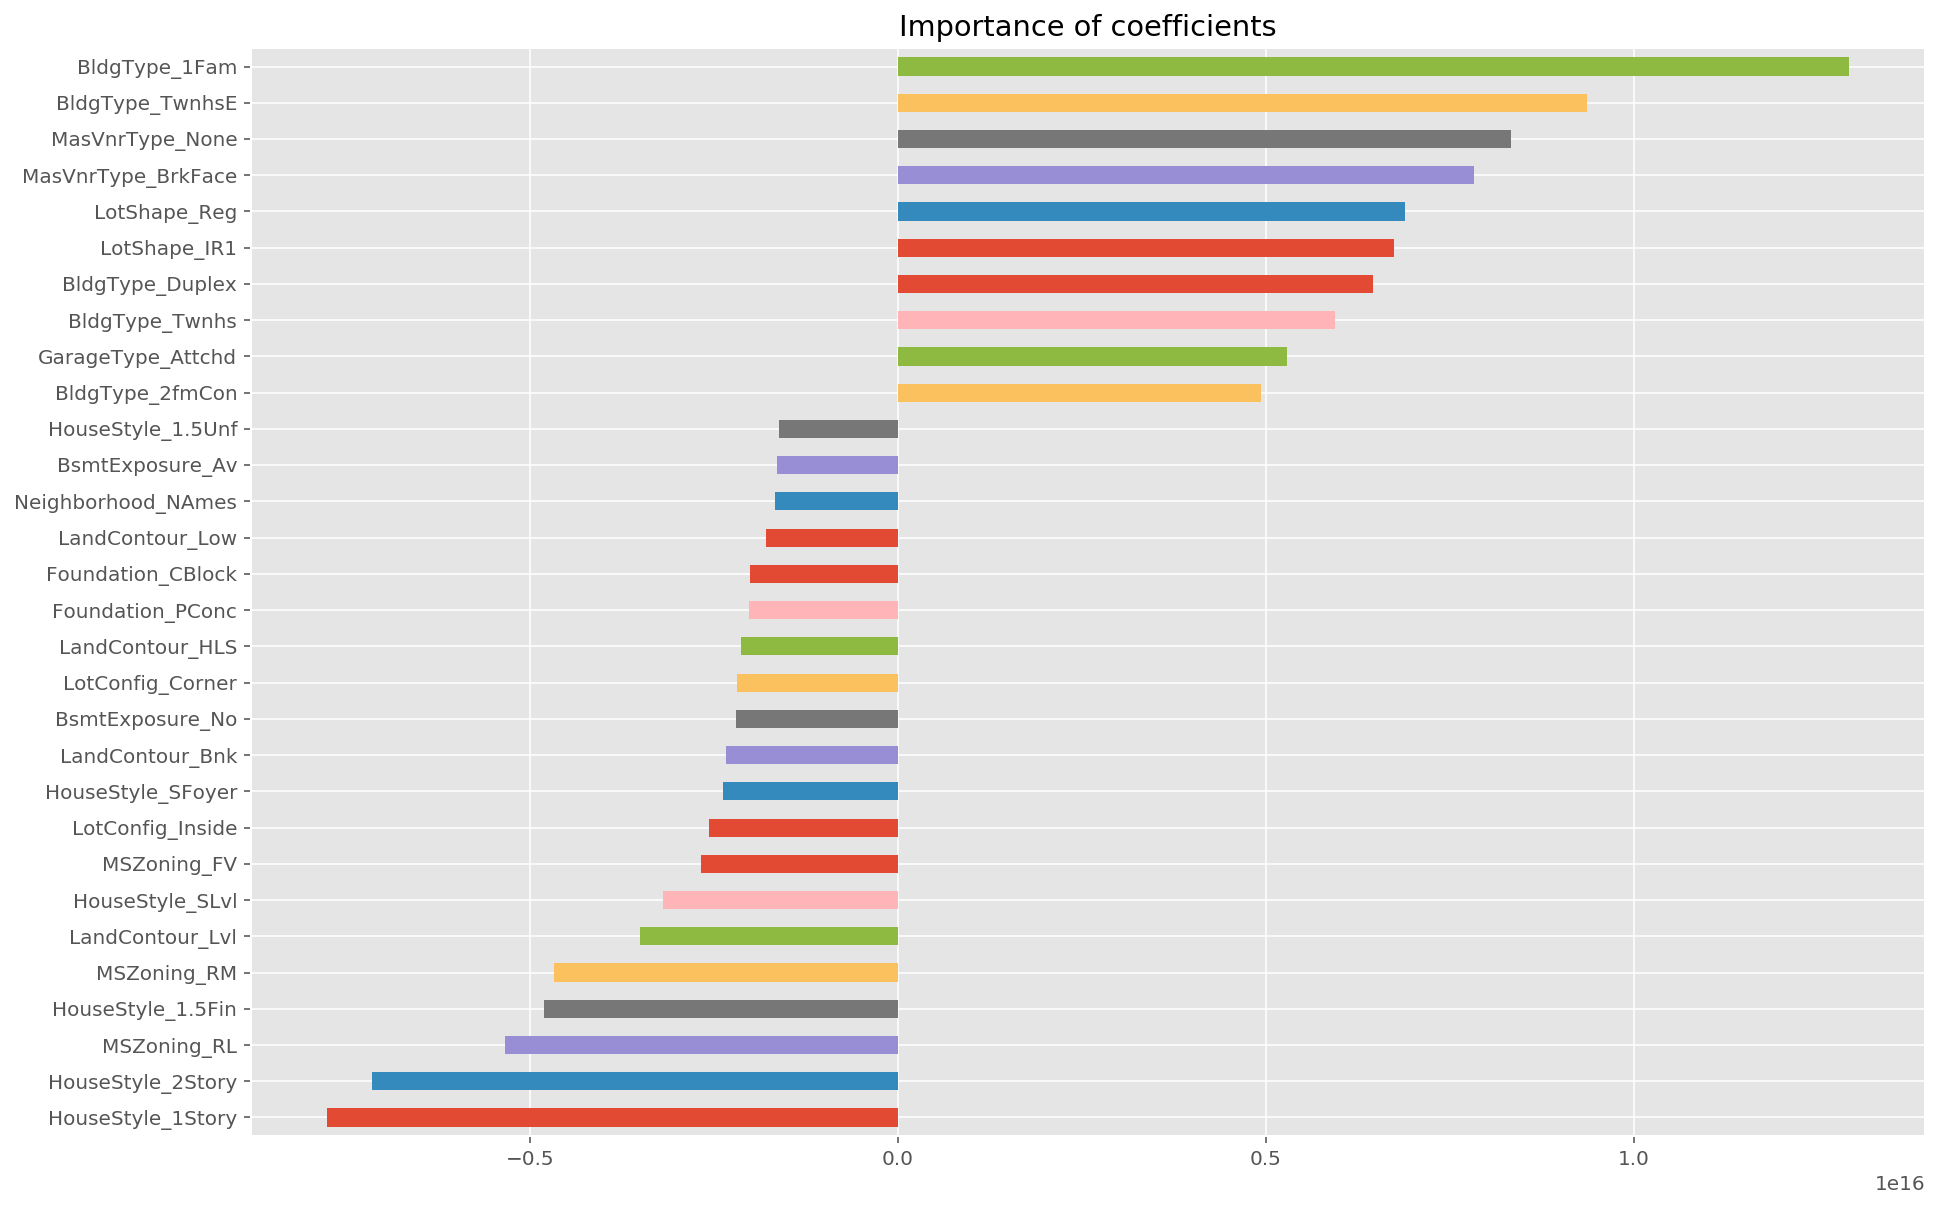

In [38]:
# Plot important coefficients
coefs = pd.concat([model_coef['coefficients'].sort_values().head(20),
                     model_coef['coefficients'].sort_values().tail(10)])
coefs.plot(kind = "barh", figsize=(15, 10))
plt.title("Importance of coefficients")
plt.show()

Fit a RidgeCV model

In [39]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X, y)

print(optimal_ridge.alpha_)

7.149428986597579


In [40]:
optimal_ridge.score(X,y)

0.8448093473806351

In [41]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.86935972 0.87067847 0.85569174 0.74238328 0.83525895 0.86717025
 0.84765203 0.81402509 0.59946954 0.85264065]
0.8154329709277759


It's a lot better than the Linear Regression, likely because there is much multicollinearity in the data which the Ridge is able to manage.

In [42]:
# fit and evaluate the data on the whole training set
model.fit(X_train,y_train)

print("Training Score:",model.score(X_train,y_train))
print("Test Score:",model.score(X_test,y_test))

Training Score: 0.8442581737633343
Test Score: 0.8640176335971227


In [43]:
# compare to ridge with optimal alpha
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X,y)
print(ridge.score(X,y))

0.8448093473806351


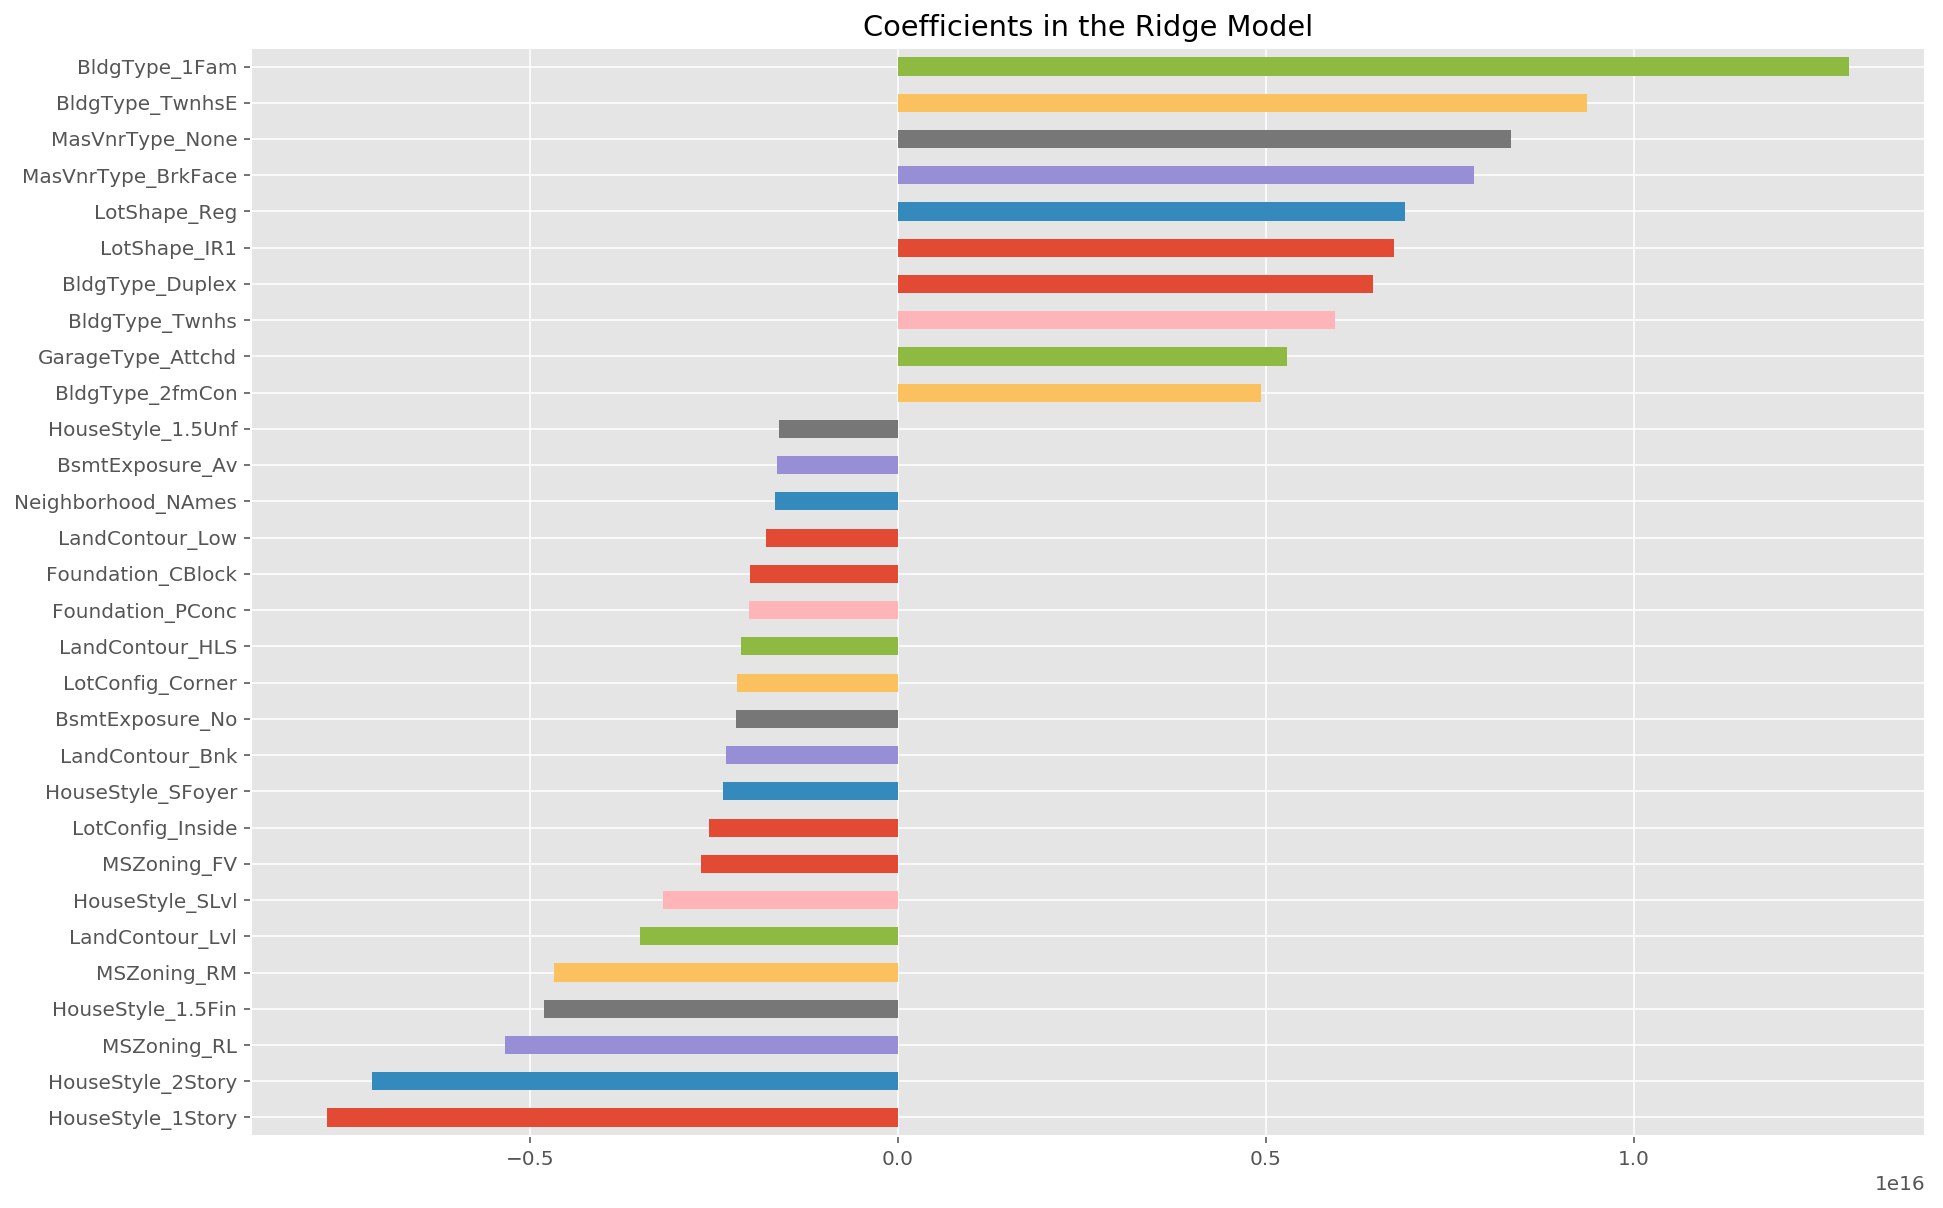

In [44]:
# Plot important coefficients
coefs = pd.concat([model_coef['coefficients'].sort_values().head(20),
                     model_coef['coefficients'].sort_values().tail(10)])
coefs.plot(kind = "barh", figsize=(15, 10))
plt.title("Coefficients in the Ridge Model")
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [45]:
import statsmodels.formula.api as sm
import patsy
from sklearn.linear_model import RidgeCV

In [46]:
# get out the residuals for training and testing, in terms of dollars.
tr_resids = y_train - optimal_ridge.predict(X_train)
te_resids = y_test- optimal_ridge.predict(X_test)

In [47]:
# things that could be done via renovation:
renovations = ['YrSold','RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']

In [48]:
renovation_f = '~ '+' + '.join(renovations)+' -1'

In [49]:
# make the renovation predictor matrix
Xren = patsy.dmatrix(renovation_f, data=house, return_type='dataframe')
Xren.shape

(1459, 68)

In [51]:
# standardize it
scaler = StandardScaler()
Xrens = scaler.fit_transform(Xren)

In [52]:
# split by year again
inds_recent = h.YrSold == 2010
Xren_tr, Xren_te = Xrens[~inds_recent.values], Xrens[inds_recent.values]

In [53]:
ren_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)

In [54]:
Xren_tr.shape

(1284, 68)

In [55]:
ren_cv.fit(Xren_tr, tr_resids)

/Users/klara/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000e-05, 1.07177e-05, ..., 9.33039e+03, 1.00000e+04]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [56]:
ren_cv.alpha_

884.0733401525063

In [57]:
ren_cv.score(Xren_tr, tr_resids)

0.16528798449551152

In [58]:
ren_cv.score(Xren_te, te_resids)

0.1878237217720891

We are explaining 19% of the variance in the remaining variance in price explained by the fixed characteristics of the house.

In [62]:
renovation_coefs = pd.DataFrame(dict(coef=ren_cv.coef_,
                                     abscoef=np.abs(ren_cv.coef_),
                                     feature=Xren.columns))

Below I am sorting by coef magnitude for the model.
 
We are predicting the residuals, the error in price for the first model overestimating the price for a house.

We can use these features to evaluate how much in dollars a renovation is worth. For example if we wanted to upgrade a fireplace from "fair" (TA) to "good" (Gd) then we would evaluate the differences in their coefficients.
The good fireplace is less negative than the average. The difference between them is an estimate of how much value we would gain making that change.

In [66]:
renovation_coefs.sort_values('abscoef', ascending=False, inplace=True)
renovation_coefs.head(15)

,coef,abscoef,feature
25,7897.298260,7897.298260,BsmtCond[T.None]
52,7897.298260,7897.298260,BsmtQual[T.None]
66,6596.769331,6596.769331,FireplaceQu[T.TA]
49,5912.081767,5912.081767,ExterQual[T.TA]
14,5519.156430,5519.156430,Exterior1st[T.Plywood]
63,-5368.503639,5368.503639,FireplaceQu[T.Gd]
61,5313.700526,5313.700526,KitchenQual[T.TA]
38,-5154.258612,5154.258612,GarageFinish[T.RFn]
53,3873.819388,3873.819388,BsmtQual[T.TA]
12,-3400.112243,3400.112243,Exterior1st[T.ImStucc]
